In [ ]:
%pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment
%pip install -q plotly==5.4.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 36.9 MB/s eta 0:00:00


In [ ]:
import xarray

print(xarray.__version__)
import numpy as np
from os import path
import os

# from aicsimageio import AICSImage
# from aicspylibczi import CziFile
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt
from skimage.io import imread, imread_collection, imsave
from skimage.io import imshow_collection
import pandas as pd
from skimage.transform import resize
from skimage import filters
from skimage.morphology import binary_dilation, binary_erosion

# from cucim.skimage.morphology import binary_erosion, disk

from skimage.filters import threshold_multiotsu
from basicpy import BaSiC
from basicpy.metrics import autotune_cost

nuc_channel_idx = 2
cyto_channel_idx = 0

2023.7.0


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob

# file_path = "/content/drive/MyDrive/Colab Notebooks/BaSiCPy-dev/Simulation/simulatedimages/"
file_path = (
    "/content/drive/MyDrive/Colab Notebooks/BaSiCPy/Simulated_data/simulatedimages/"
)

flatfield_true = np.load(
    path.join(file_path, f"flatfield_true.npy"),
)
darkfield_true = np.load(
    path.join(file_path, f"darkfield_true.npy"),
)
baseline_true = np.load(
    path.join(file_path, f"baseline_true.npy"),
)

# Without darkfield

In [ ]:
flatfields_wo_darks = {}
baselines_wo_darks = {}
parameters_df_wo_darks = {}
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    flatfields_wo_darks[channel_index] = np.load(
        path.join(file_path, f"wo_darkfield_flatfields_channel_{channel_index}_2.npy"),
        allow_pickle=True,
    )
    baselines_wo_darks[channel_index] = np.load(
        path.join(file_path, f"wo_darkfield_baselines_channel_{channel_index}_2.npy"),
        allow_pickle=True,
    )
    parameters_df_wo_darks[channel_index] = pd.read_csv(
        path.join(file_path, f"wo_darkfield_parameters_channel_{channel_index}_2.csv"),
        index_col=0,
    )

In [ ]:
parameters_df_wo_darks[0].head()

,smoothness_flatfield,fitting_mode,sort_intensity,channel_index,use_weight,rep,entropy,fourier_L0_norm,autotune_cost
0,0.001,ladmap,False,0,True,0,5.356484,0.400636,4001.059364
1,0.001,ladmap,False,0,True,1,5.365500,0.397946,3974.186011
2,0.001,ladmap,False,0,True,2,5.361900,0.400788,4002.582245
3,0.001,ladmap,False,0,True,3,5.354816,0.399398,3988.699476
4,0.001,ladmap,False,0,True,4,5.356189,0.399474,3989.463650


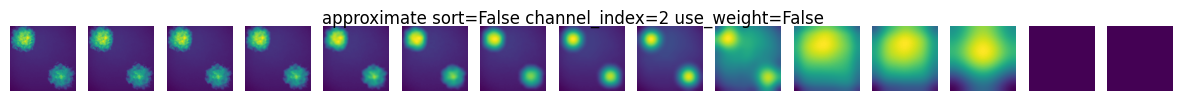

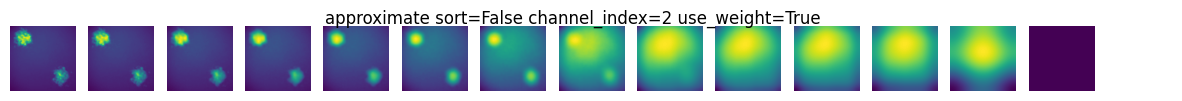

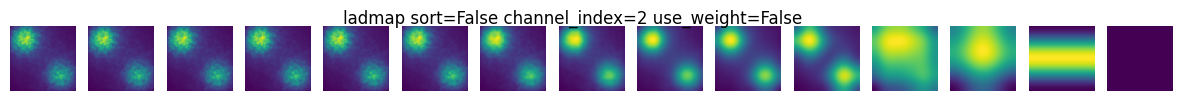

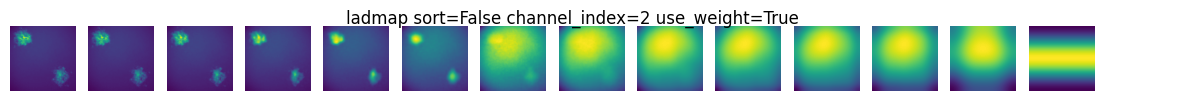

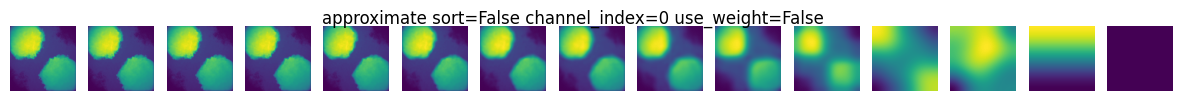

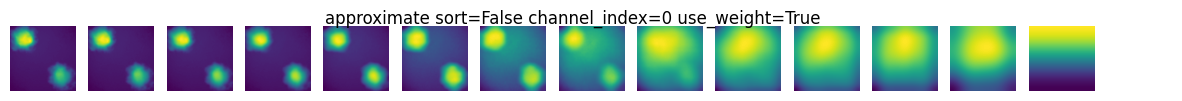

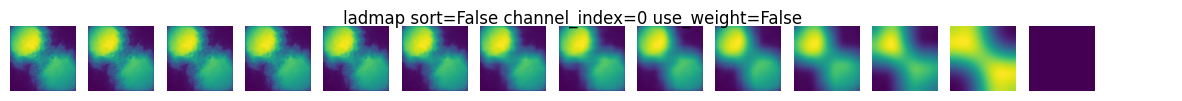

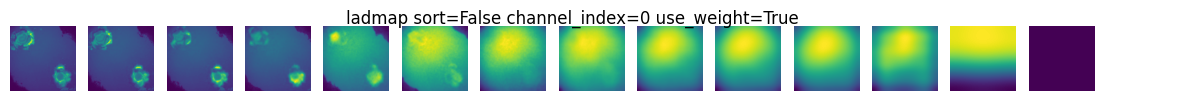

In [ ]:
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    for (
        fitting_mode,
        sort_intensity,
        channel_index,
        use_weight,
    ), grp in parameters_df_wo_darks[channel_index].groupby(
        ["fitting_mode", "sort_intensity", "channel_index", "use_weight"]
    ):
        df = grp.sort_values("smoothness_flatfield").query("rep==0")
        fig, axes = plt.subplots(1, len(df), figsize=(15, 1))
        for ax, (i, row) in zip(np.ravel(axes), df.iterrows()):
            ax.imshow(flatfields_wo_darks[channel_index][i])
            ax.axis("off")
        fig.suptitle(
            f"{fitting_mode} sort={sort_intensity} channel_index={channel_index} use_weight={use_weight}"
        )
        fig.show()

In [ ]:
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    for i, row in parameters_df_wo_darks[channel_index].iterrows():
        flatfield = flatfields_wo_darks[channel_index][i]
        if not np.any(np.isfinite(flatfield)):
            continue
        parameters_df_wo_darks[channel_index].loc[i, "mean_abs_error"] = np.mean(
            np.abs(flatfield_true - flatfield)
        )
#    parameters_df_wo_dark.loc[i,"autotune_metric"] = autotune_cost(
#        flatfield,
#
#    )

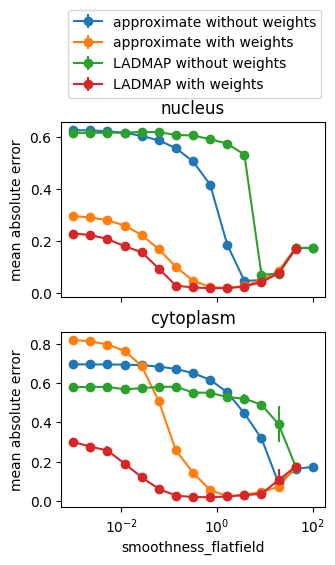

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(3.4, 5), sharex=True)
for ax, channel_index in zip(axes, [nuc_channel_idx, cyto_channel_idx]):
    df = parameters_df_wo_darks[channel_index].query(
        f"sort_intensity==False and channel_index=={channel_index}"
    )
    df = (
        df.groupby(["fitting_mode", "use_weight", "smoothness_flatfield"])
        .agg(["mean", "std"])
        .reset_index()
    )
    for (fitting_mode, use_weight), grp in df.groupby(["fitting_mode", "use_weight"]):
        ax.errorbar(
            grp["smoothness_flatfield"],
            grp["mean_abs_error"]["mean"],
            grp["mean_abs_error"]["std"] * 2,
            fmt="o-",
            label=f"{'LADMAP' if fitting_mode=='ladmap' else 'approximate'} {'with' if use_weight else 'without'} weights",
        )
        ax.set_xscale("log")
    ax.set_ylabel("mean absolute error")
    ax.set_title(
        {nuc_channel_idx: "nucleus", cyto_channel_idx: "cytoplasm"}[channel_index]
    )
axes[1].set_xlabel("smoothness_flatfield")
axes[0].legend(loc="lower left", bbox_to_anchor=(0, 1.1))

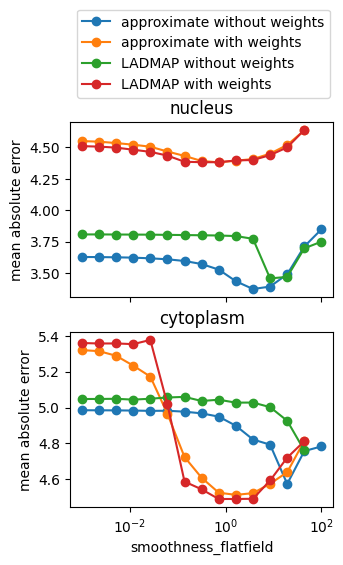

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(3.4, 5), sharex=True)
for ax, channel_index in zip(axes, [nuc_channel_idx, cyto_channel_idx]):
    df = parameters_df_wo_darks[channel_index].query(
        f"sort_intensity==False and channel_index=={channel_index}"
    )
    df = (
        df.groupby(["fitting_mode", "use_weight", "smoothness_flatfield"])
        .agg(["mean", "std"])
        .reset_index()
    )
    for (fitting_mode, use_weight), grp in df.groupby(["fitting_mode", "use_weight"]):
        ax.errorbar(
            grp["smoothness_flatfield"],
            grp["entropy"]["mean"],
            # grp["autotune_cost"]["std"]*2,
            fmt="o-",
            label=f"{'LADMAP' if fitting_mode=='ladmap' else 'approximate'} {'with' if use_weight else 'without'} weights",
        )
        # ax.set_ylim(4,5)
        ax.set_xscale("log")
    ax.set_ylabel("mean absolute error")
    ax.set_title(
        {nuc_channel_idx: "nucleus", cyto_channel_idx: "cytoplasm"}[channel_index]
    )
axes[1].set_xlabel("smoothness_flatfield")
axes[0].legend(loc="lower left", bbox_to_anchor=(0, 1.1))

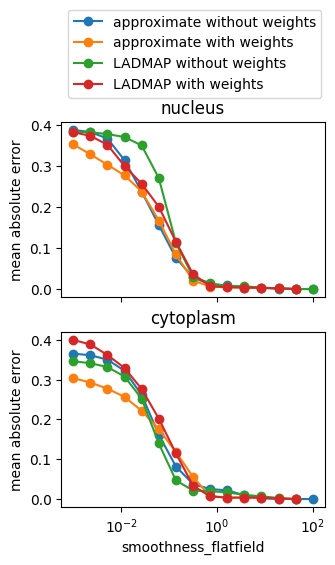

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(3.4, 5), sharex=True)
for ax, channel_index in zip(axes, [nuc_channel_idx, cyto_channel_idx]):
    df = parameters_df_wo_darks[channel_index].query(
        f"sort_intensity==False and channel_index=={channel_index}"
    )
    df = (
        df.groupby(["fitting_mode", "use_weight", "smoothness_flatfield"])
        .agg(["mean", "std"])
        .reset_index()
    )
    for (fitting_mode, use_weight), grp in df.groupby(["fitting_mode", "use_weight"]):
        ax.errorbar(
            grp["smoothness_flatfield"],
            grp["fourier_L0_norm"]["mean"],
            # grp["autotune_cost"]["std"]*2,
            fmt="o-",
            label=f"{'LADMAP' if fitting_mode=='ladmap' else 'approximate'} {'with' if use_weight else 'without'} weights",
        )
        # ax.set_ylim(4,5)
        ax.set_xscale("log")
    ax.set_ylabel("mean absolute error")
    ax.set_title(
        {nuc_channel_idx: "nucleus", cyto_channel_idx: "cytoplasm"}[channel_index]
    )
axes[1].set_xlabel("smoothness_flatfield")
axes[0].legend(loc="lower left", bbox_to_anchor=(0, 1.1))